In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import os


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [5]:
import os
path_2 = os.path.join(path, "Master Folder")

train_dir = os.path.join(path, "Master Folder", "train")
val_dir = os.path.join(path, "Master Folder", "valid")
test_dir = os.path.join(path, "Master Folder", "test")


In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, stride=1, downsample=None):
        super().__init__()
        self.conv1 = layers.Conv2D(filters,
                                   kernel_size=3,
                                   strides=stride,
                                   padding='same')

        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters,
                                   kernel_size=3,
                                   strides=1,
                                   padding='same')

        self.bn2 = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.3)
        self.downsample = downsample

    def call(self, x, training=False):
        identity = x
        if self.downsample:
            identity = self.downsample(x, training=training)

        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out - self.dropout(out, training=training)

        out += identity
        out = self.relu(out)
        return out



def make_layer(filters, blocks, stride=1):
    downsample = None
    if stride != 1:
        downsample = tf.keras.Sequential([
            layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False),
            layers.BatchNormalization()
        ])

    layers_list = [ResidualBlock(filters, stride, downsample)]
    for _ in range(1, blocks):
        layers_list.append(ResidualBlock(filters))

    return tf.keras.Sequential(layers_list)


# ResNet-18 Model
class ResNet18(tf.keras.Model):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.maxpool = layers.MaxPool2D(pool_size=3, strides=2, padding='same')

        self.layer1 = make_layer(64, 2)
        self.layer2 = make_layer(128, 2, stride=2)
        self.layer3 = make_layer(256, 2, stride=2)
        self.layer4 = make_layer(512, 2, stride=2)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes)

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        x = self.avgpool(x)
        x = self.fc(x)
        return x

model2 = ResNet18(num_classes=4)


In [8]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'

)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)


Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

model2.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.2568 - loss: 3.3310
Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2564 - loss: 3.3105 - val_accuracy: 0.2222 - val_loss: 1.4323
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.2745 - loss: 2.3645
Epoch 2: val_accuracy improved from 0.22222 to 0.27778, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 431ms/step - accuracy: 0.2743 - loss: 2.3697 - val_accuracy: 0.2778 - val_loss: 13.4317
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.2675 - loss: 2.3267
Epoch 3: val_accuracy did not improve from 0.27778
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.2669 - loss: 2.3232 - val_accuracy: 0.2500 - val_loss: 5.3695
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.2347 - loss: 1.8606
Epoch 4: val_accuracy did not improve from 0.27778
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - accuracy: 0.2348 - loss: 1.8601 - val_accuracy: 0.2500 - val_loss: 4.1204
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.2625 - loss: 1.8520
Epoch 5: val_accuracy did not improve from 0.27778
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 417ms/step - accuracy: 0.2624 - loss: 1.8519 - val_accuracy: 0.2500 - val_loss: 3.9372
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.2465 - loss: 1.8828
Epoch 6: val_accuracy did not 

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.2841 - loss: 1.5713 - val_accuracy: 0.3056 - val_loss: 1.4190
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.2702 - loss: 1.7536
Epoch 13: val_accuracy did not improve from 0.30556
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.2701 - loss: 1.7578 - val_accuracy: 0.2500 - val_loss: 1.3846
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.2427 - loss: 2.0397
Epoch 14: val_accuracy did not improve from 0.30556
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.2427 - loss: 2.0372 - val_accuracy: 0.1667 - val_loss: 1.7983
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.2374 - loss: 1.8309
Epoch 15: val_accuracy did not improve from 0.30556
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.2367 - loss: 1.8309 - val_accuracy: 0.1667 - val_loss: 1.4137
Epoch 16/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.2479 - loss: 1.7714
Epoch 16: val_accuracy d

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 509ms/step - accuracy: 0.2661 - loss: 1.5754 - val_accuracy: 0.4167 - val_loss: 1.7595
Epoch 39/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.2582 - loss: 1.4142
Epoch 39: val_accuracy did not improve from 0.41667
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 422ms/step - accuracy: 0.2576 - loss: 1.4156 - val_accuracy: 0.3056 - val_loss: 1.7463
Epoch 40/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.2472 - loss: 1.4973
Epoch 40: val_accuracy did not improve from 0.41667
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 420ms/step - accuracy: 0.2468 - loss: 1.4994 - val_accuracy: 0.3333 - val_loss: 1.3898
Epoch 41/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.2744 - loss: 1.5052
Epoch 41: val_accuracy did not improve from 0.41667
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.2737 - loss: 1.5055 - val_accuracy: 0.3056 - val_loss: 1.4029
Epoch 42/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.2522 - loss: 1.4802
Epoch 42: val_accuracy d

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

model2.evaluate(test_generator)


Found 38 images belonging to 4 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2412 - loss: 1.5482


[1.5403637886047363, 0.2368421107530594]

In [12]:
import numpy as np

# Get predictions
predictions = model2.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")


target_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Accuracy: 0.3684
Classification Report:
              precision    recall  f1-score   support

       Angry       0.40      0.20      0.27        10
       Other       0.25      0.33      0.29         6
         Sad       0.33      0.09      0.14        11
       happy       0.41      0.82      0.55        11

    accuracy                           0.37        38
   macro avg       0.35      0.36      0.31        38
weighted avg       0.36      0.37      0.31        38

Confusion Matrix:
[[2 2 2 4]
 [2 2 0 2]
 [0 3 1 7]
 [1 1 0 9]]


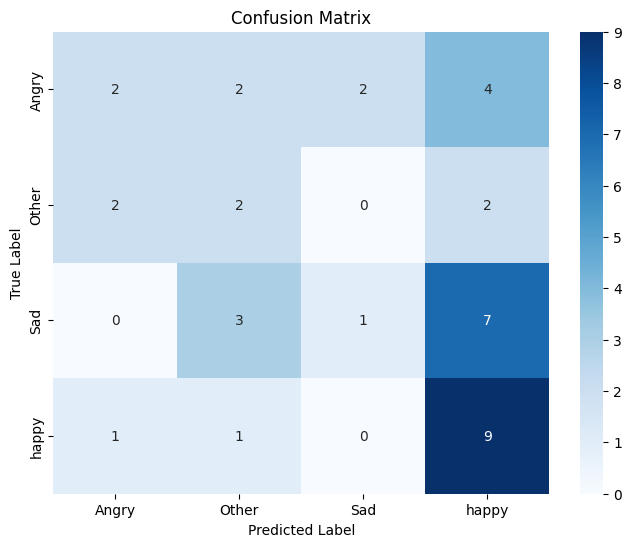

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
